In [1]:
from IPython.display import clear_output, display, HTML
from urllib.parse import urlencode
from datetime import datetime, timedelta
from collections import OrderedDict
import queue
import requests
import threading
import pandas as pd
import itertools
from math import isnan
import pytz
import json
import csv
import matplotlib.pyplot as plt
from matplotlib.finance import candlestick2_ochl, candlestick_ochl
from matplotlib.dates import date2num, DateFormatter
from matplotlib import pyplot as plt, ticker, style
from time import sleep
    
style.use('ggplot')

TOP_ITEMS_COUNT = 10
DATA_TIMEZONE = pytz.timezone("US/Eastern")
CLIENT_TIMEZONE = pytz.timezone('America/Los_Angeles')
periods = [1, 5, 15, 30, 60, "All day"]

def get_now():
    now = datetime.now(tz=CLIENT_TIMEZONE)
    weekday = now.isoweekday()
    if weekday > 5:
        now = (now - timedelta(days=weekday - 5)).replace(hour=15)
    return now

now = get_now()    
now

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


datetime.datetime(2018, 4, 27, 15, 45, 22, 379284, tzinfo=<DstTzInfo 'America/Los_Angeles' PDT-1 day, 17:00:00 DST>)

In [2]:
def get_symbols():
    with open("n14_symbols.csv", "r") as f:
        symbols = f.read().split()
    return list(set(symbols))
symbols = get_symbols()
len(symbols)

3198

In [3]:
def get_minute_data(symbol, now):
    now = now.replace(second=0, microsecond=0)
    start = now.replace(hour=6, minute=30)
    if start > now:
        raise ValueError("It's too early")
    
    url = "https://query1.finance.yahoo.com/v7/finance/chart/{}?period1={:.0f}&period2={:.0f}"\
          "&interval=1m&indicators=quote&includeTimestamps=true&"\
          "events=div%7Csplit%7Cearn".format(symbol, start.timestamp(), now.timestamp())
    
    try:
        page = requests.get(url)
    except Exception as e:
        print("Exception while getting {}".format(symbol), e)
    else:
        result = page.json()['chart']['result']
        if not result:
            print(symbol, page.json())
            return

        data = result[0]
        quote = data['indicators']['quote'][0]
        if 'timestamp' not in data:
            return
        times = data['timestamp']
        period = data['meta']['currentTradingPeriod']['regular']
        start, end = period['start'], period['end']
        del quote['volume']
        quote['index'] = [datetime.fromtimestamp(t, tz=DATA_TIMEZONE).astimezone(now.tzinfo) for t in times]

        return quote

raw_data = get_minute_data('AAPL', now) # SRCE
raw_data

{'close': [164.11000061035156,
  163.7698974609375,
  163.6699981689453,
  163.80999755859375,
  163.57000732421875,
  163.60000610351562,
  163.36000061035156,
  163.4600067138672,
  163.3699951171875,
  163.4199981689453,
  163.0399932861328,
  163.19000244140625,
  163.2899932861328,
  163.2100067138672,
  163.1699981689453,
  163.14999389648438,
  162.9199981689453,
  162.97999572753906,
  162.8699951171875,
  163.02999877929688,
  162.8000030517578,
  162.50999450683594,
  162.2100067138672,
  162.19000244140625,
  162.2449951171875,
  162.35000610351562,
  162.24000549316406,
  162.05499267578125,
  161.99000549316406,
  162.0399932861328,
  162.0500030517578,
  162.0399932861328,
  161.7050018310547,
  161.67999267578125,
  161.51499938964844,
  161.4600067138672,
  161.5850067138672,
  161.73680114746094,
  161.6300048828125,
  161.60000610351562,
  161.35000610351562,
  161.08999633789062,
  160.8699951171875,
  160.8699951171875,
  160.72019958496094,
  161.19000244140625,
  

In [4]:
def get_df_from_raw_data(rd):
    assert rd and "index" in rd, "An unexpected input: {}".format(rd)
    index = rd['index']
    del rd['index']
    df = pd.DataFrame(rd, index=index)
    df['n_low'] = df.low < df.low.shift(1)
    df['bear_velocity'] = df.n_low.rolling(window=10).sum() * 10
    df['n_high'] = df.high > df.high.shift(1)
    df['bull_velocity'] = df.n_high.rolling(window=10).sum() * 10

    df['min_low'] = df.low.rolling(window=len(df), min_periods=1).min()
    df['min_low_open'] = (df.min_low / df.open - 1) * 100
    df['close_min_low'] = (df.close / df.min_low - 1) * 100
    return df

get_df_from_raw_data(raw_data)[:10]

,close,high,low,open,n_low,bear_velocity,n_high,bull_velocity,min_low,min_low_open,close_min_low
2018-04-27 06:30:00-07:00,164.110001,164.250000,163.800003,164.080002,False,NaN,False,NaN,163.800003,-0.170648,0.189254
2018-04-27 06:31:00-07:00,163.769897,164.122192,163.750000,164.119995,True,NaN,False,NaN,163.750000,-0.225442,0.012151
2018-04-27 06:32:00-07:00,163.669998,163.871002,163.619995,163.759995,True,NaN,False,NaN,163.619995,-0.085491,0.030560
2018-04-27 06:33:00-07:00,163.809998,163.839996,163.471207,163.660004,True,NaN,False,NaN,163.471207,-0.115359,0.207248
2018-04-27 06:34:00-07:00,163.570007,163.809998,163.550003,163.803802,False,NaN,False,NaN,163.471207,-0.203045,0.060439
2018-04-27 06:35:00-07:00,163.600006,163.610001,163.259995,163.559998,True,NaN,False,NaN,163.259995,-0.183421,0.208264
2018-04-27 06:36:00-07:00,163.360001,163.740005,163.360001,163.639999,False,NaN,True,NaN,163.259995,-0.232220,0.061256
2018-04-27 06:37:00-07:00,163.460007,163.460007,163.220001,163.429993,True,NaN,False,NaN,163.220001,-0.128490,0.147044
2018-04-27 06:38:00-07:00,163.369995,163.419998,163.190002,163.399994,True,NaN,False,NaN,163.190002,-0.128514,0.110296
2018-04-27 06:39:00-07:00,163.419998,163.449905,163.350006,163.350006,False,60.0,True,20.0,163.190002,-0.097951,0.140937


In [5]:
def load_data(symbols, time):
    
    num_worker_threads = 100
    
    def worker():
        while True:
            symbol = q.get()
            if symbol is None:
                break
            
            # GET DATA
            data = get_minute_data(symbol, time)
            if data is not None:
                r.put((symbol, data))
            
            q.task_done()

    q = queue.Queue() # queue with arguments for the 'get_transactions' function
    r = queue.Queue() # queue with raw responses

    threads = []
    for i in range(num_worker_threads):
        t = threading.Thread(target=worker)
        t.start()
        threads.append(t)

    for symbol in symbols:
        q.put(symbol)

    # block until all tasks are done
    q.join()

    # stop workers
    for i in range(num_worker_threads):
        q.put(None)

    for t in threads:
        t.join()
    
    # get and save data
    minute_data = {}
    symbols_sort_data = []
    while True:
        try:
            symbol, raw_data = r.get(block=False)
        except queue.Empty:
            break
        else:
            minute_data[symbol] = raw_data

            df = pd.DataFrame(dict(low=raw_data['low']), index=raw_data['index'])
            if len(df):
                df['n_low'] = df.low < df.low.shift(1)
                df['bear_velocity'] = df.n_low.rolling(window=10).sum()
                last_minute_bear_velicity = df.bear_velocity[-1]
                symbols_sort_data.append((last_minute_bear_velicity, symbol))
    
    top_symbols = [s[1] for s in sorted(symbols_sort_data, reverse=True)][:10]
    minute_data_for_top_symbols = [(symbol, get_df_from_raw_data(minute_data[symbol]))
                                   for symbol in top_symbols]
    
    return minute_data_for_top_symbols

load_data(("SRCE", "GOOG"), now)

[('GOOG',
                                   close         high          low         open  \
  2018-04-27 06:30:00-07:00  1045.310059  1046.385010  1043.300049  1046.385010   
  2018-04-27 06:31:00-07:00  1046.449951  1046.989990  1045.969971  1046.875000   
  2018-04-27 06:32:00-07:00  1047.000000  1047.530029  1046.949951  1046.949951   
  2018-04-27 06:33:00-07:00  1047.500000  1047.819946  1047.500000  1047.819946   
  2018-04-27 06:34:00-07:00  1048.719971  1048.719971  1046.382446  1047.895020   
  2018-04-27 06:35:00-07:00  1048.339966  1048.339966  1047.979980  1047.979980   
  2018-04-27 06:36:00-07:00  1048.550049  1049.130005  1048.060059  1048.060059   
  2018-04-27 06:37:00-07:00  1047.400024  1048.800049  1047.000000  1048.800049   
  2018-04-27 06:38:00-07:00  1047.710327  1047.710327  1047.540283  1047.540283   
  2018-04-27 06:39:00-07:00  1047.219971  1048.000000  1045.880005  1048.000000   
  2018-04-27 06:40:00-07:00  1045.109985  1047.560059  1045.109985  1047.5600

10m Bear Velocity,Min Low / Open,Symbol,Close / Min Low,10m Bull Velocity
90.0,-1.3724951847693623,FOXA,1.2245995629607709,20.0
80.0,-0.48082538253557683,UBSH,0.41786326347990066,10.0
80.0,-0.8946337144912775,HAIN,0.869275259806912,20.0
80.0,-1.7480606329391302,FOX,1.6379605579045942,10.0
80.0,-1.714286025689571,CAR,1.723425734394568,30.0
80.0,-0.3900931561415022,BOKF,0.3328803302495631,40.0
80.0,-5.817809532349627,ANAB,5.915783139111919,40.0
80.0,-0.47142652062144297,AMZN,0.3007548427082618,40.0
80.0,-0.3673263488297107,ACGL,0.3441056529995379,0.0
70.0,-0.5733084713249403,WATT,0.4393291327669635,30.0


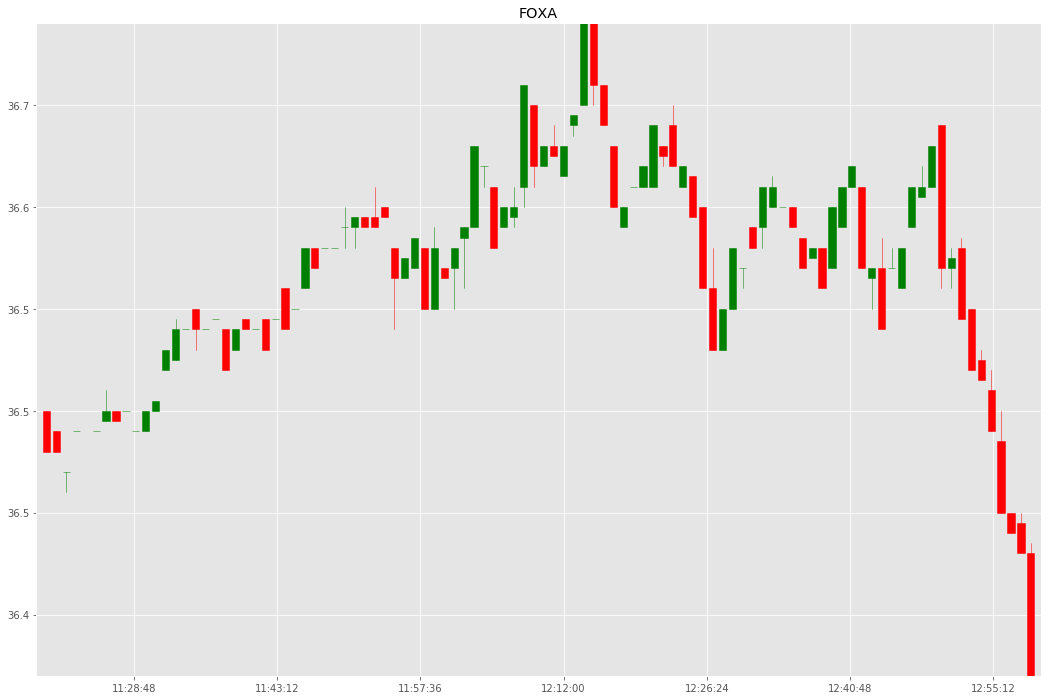

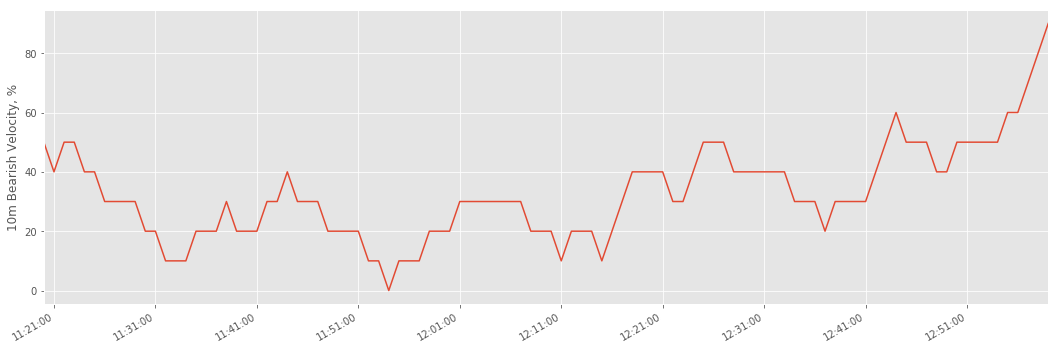

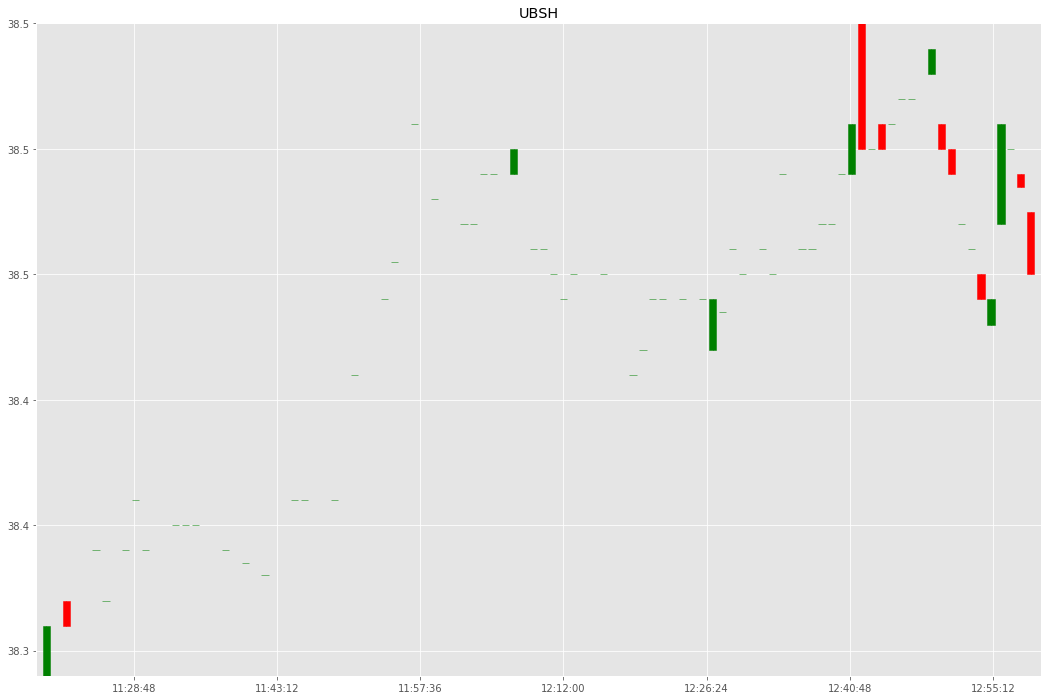

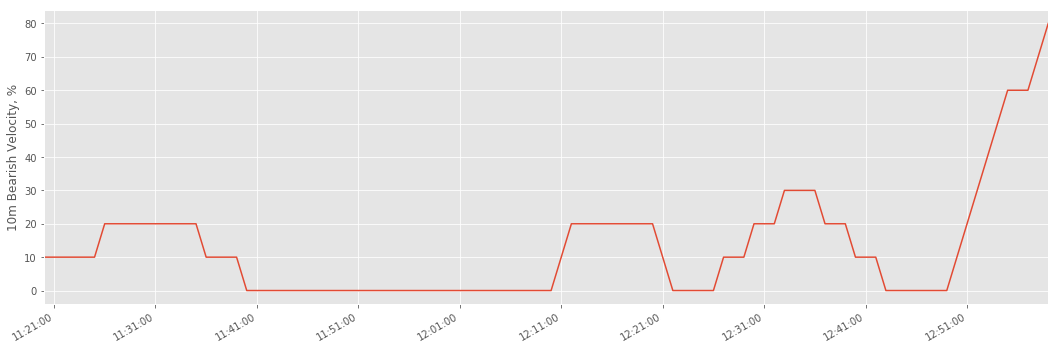

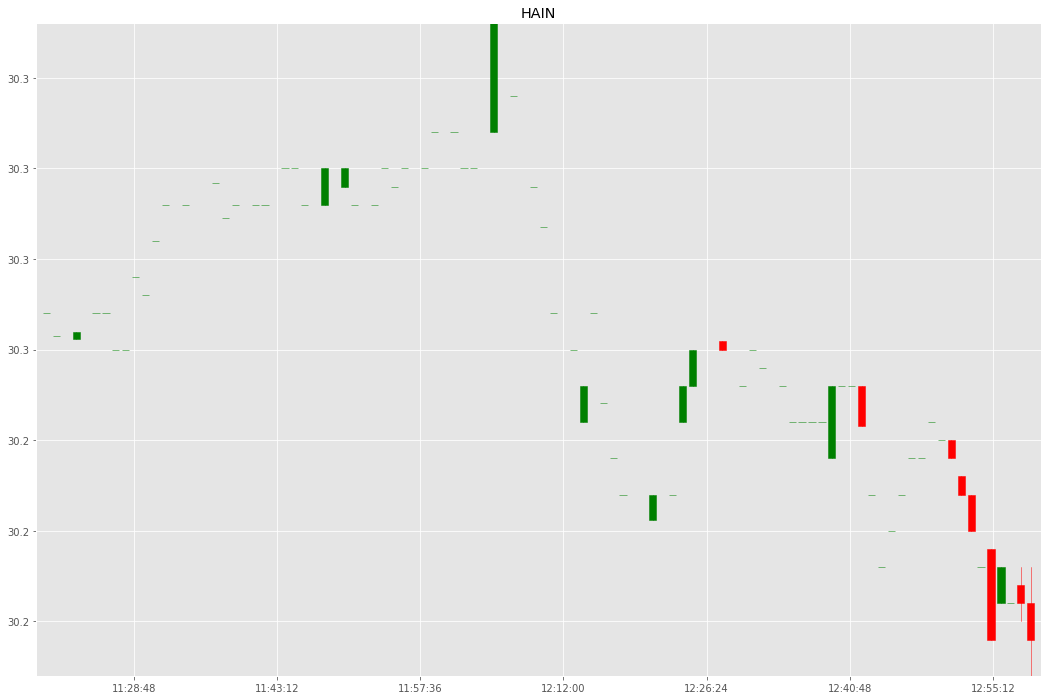

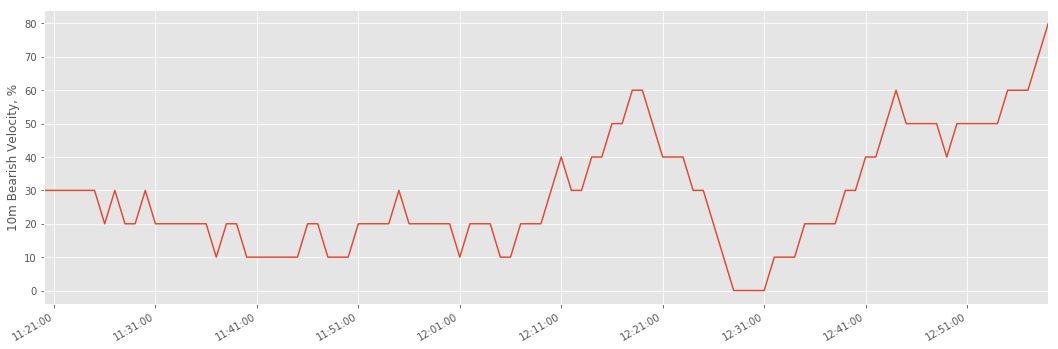

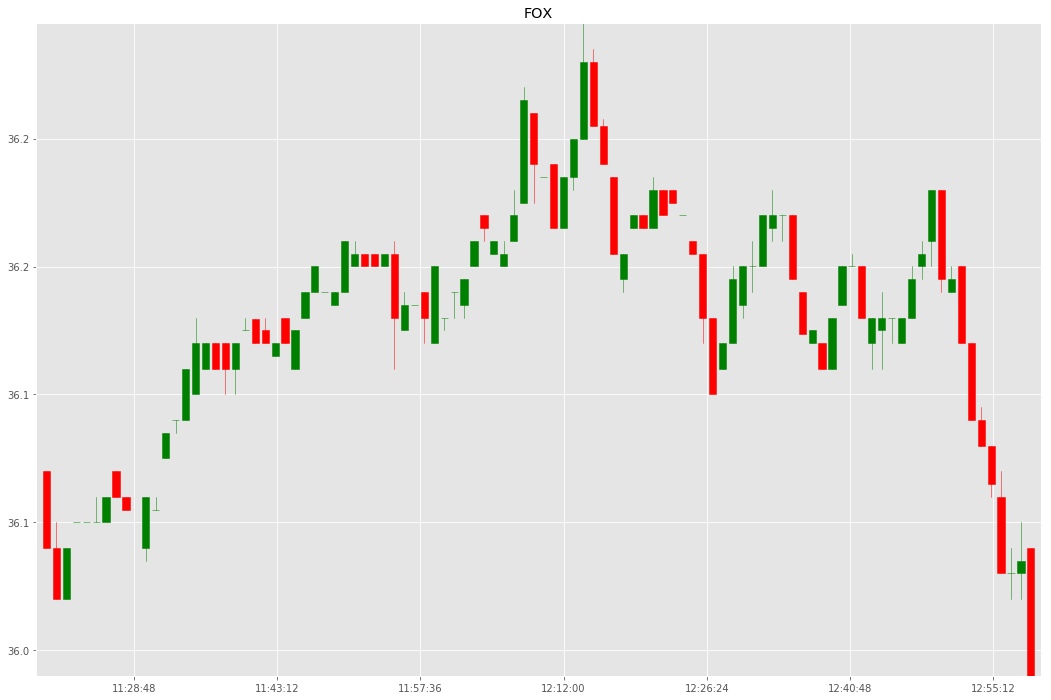

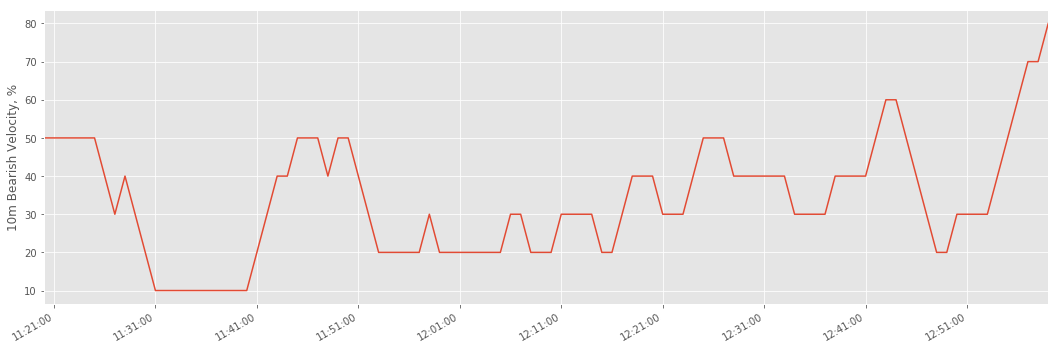

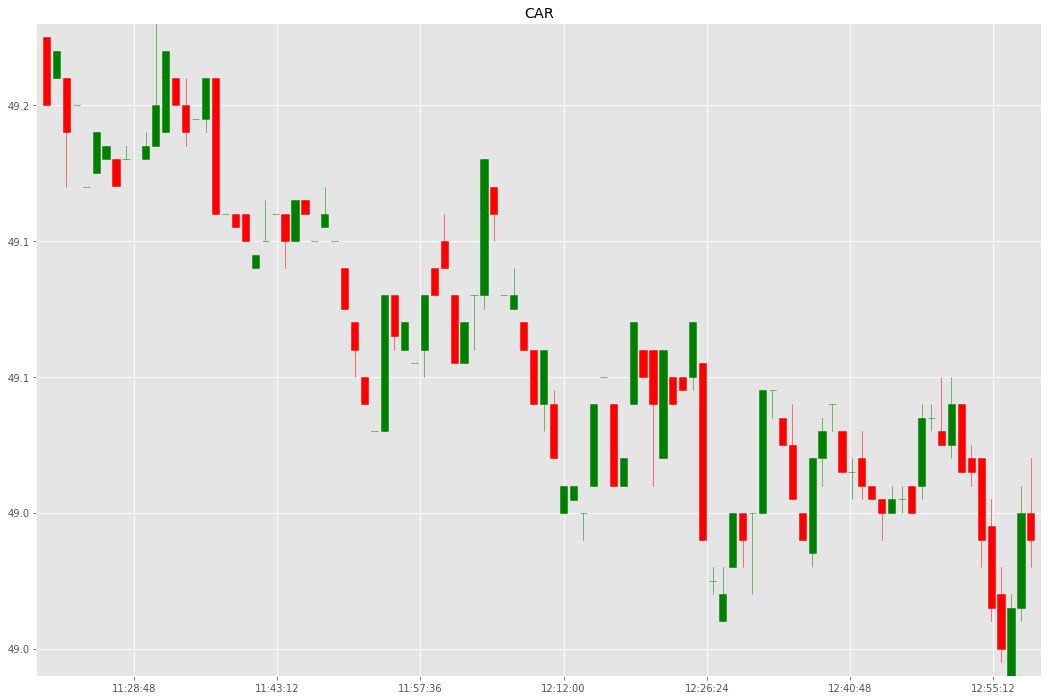

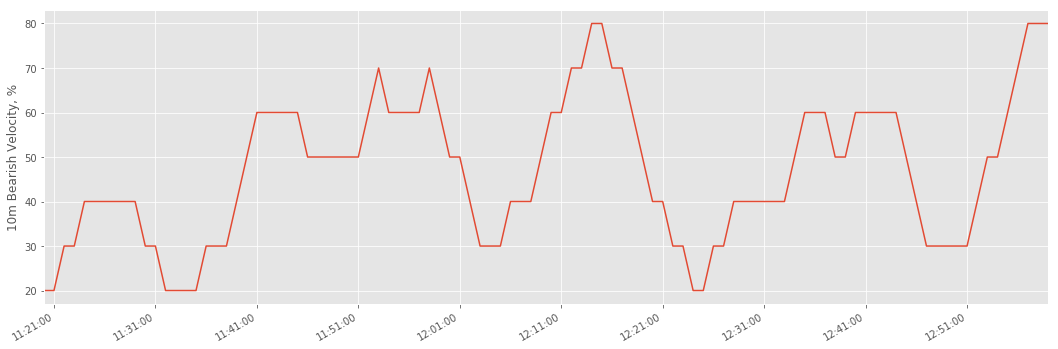

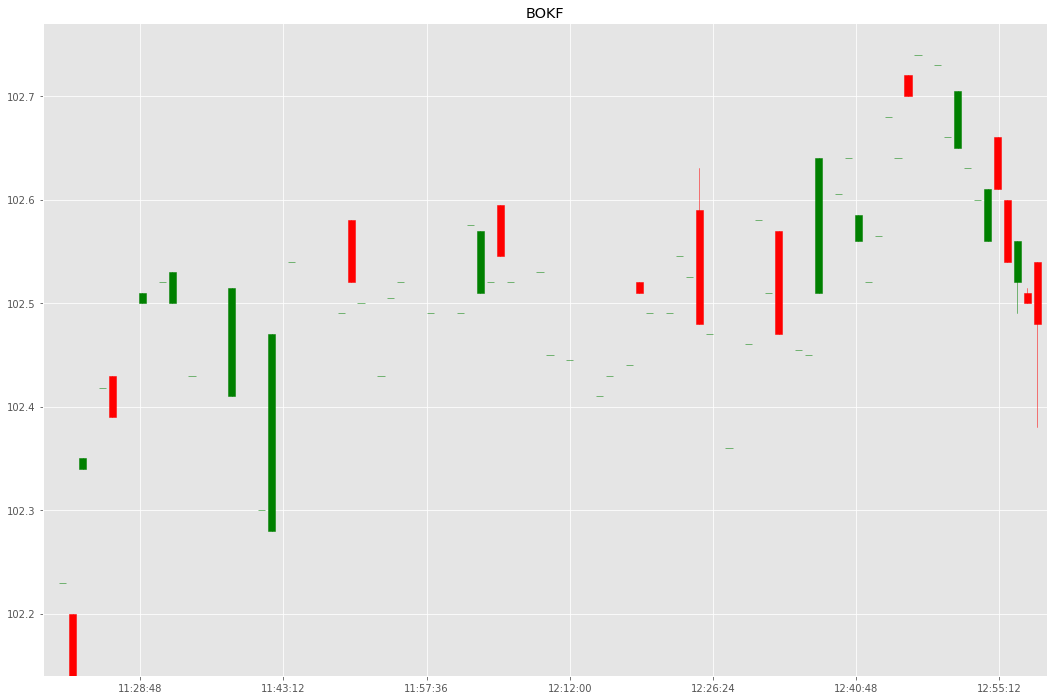

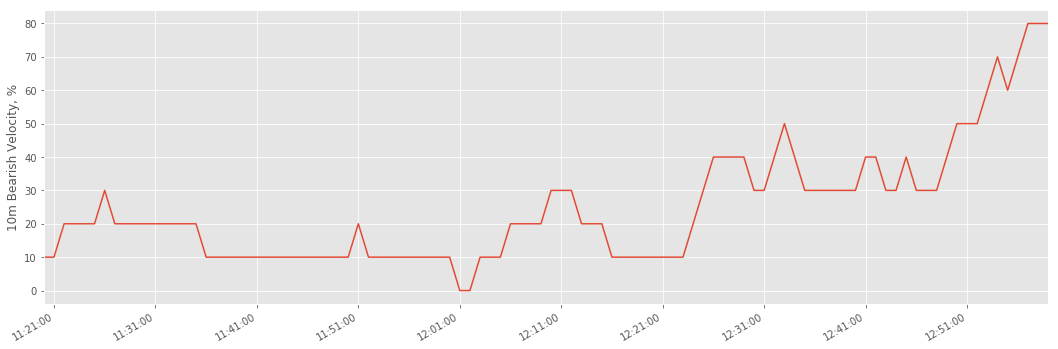

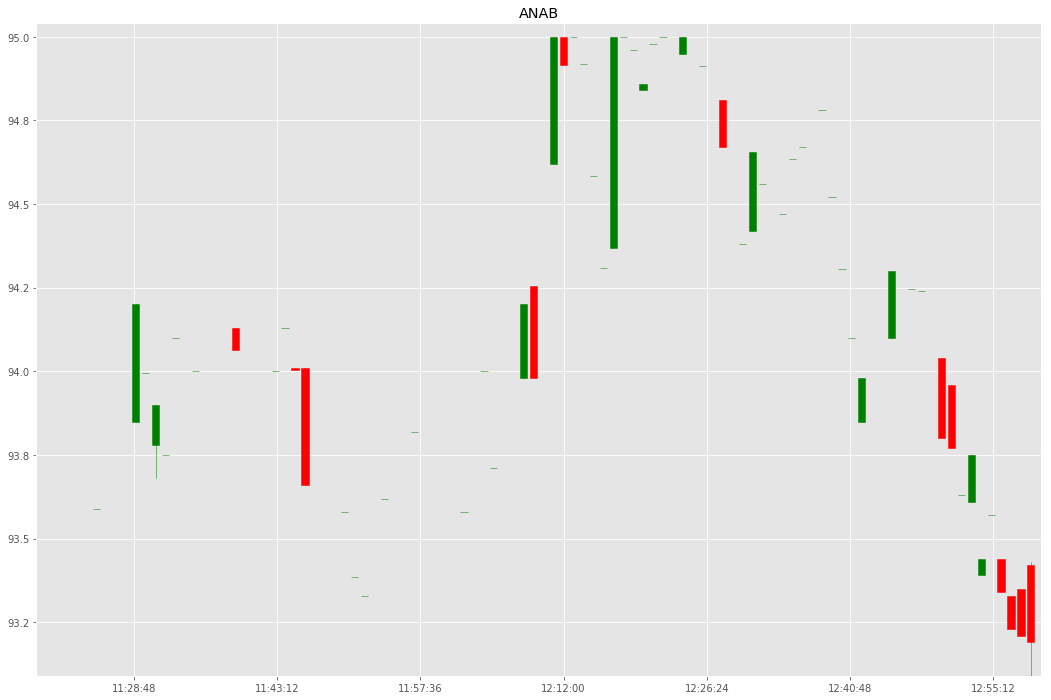

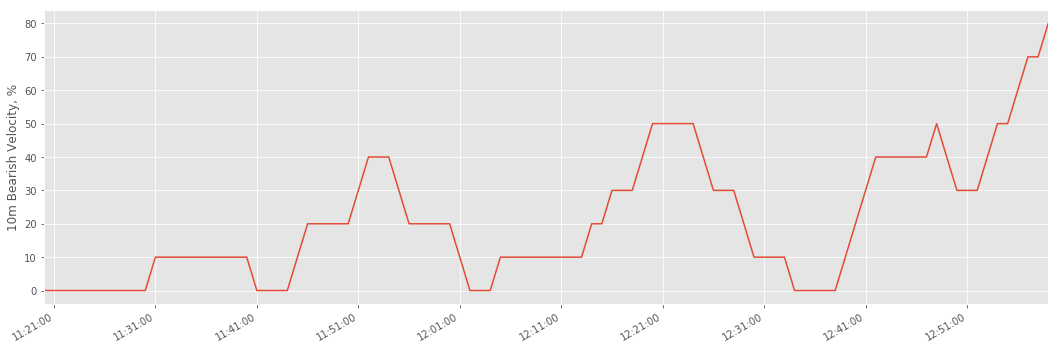

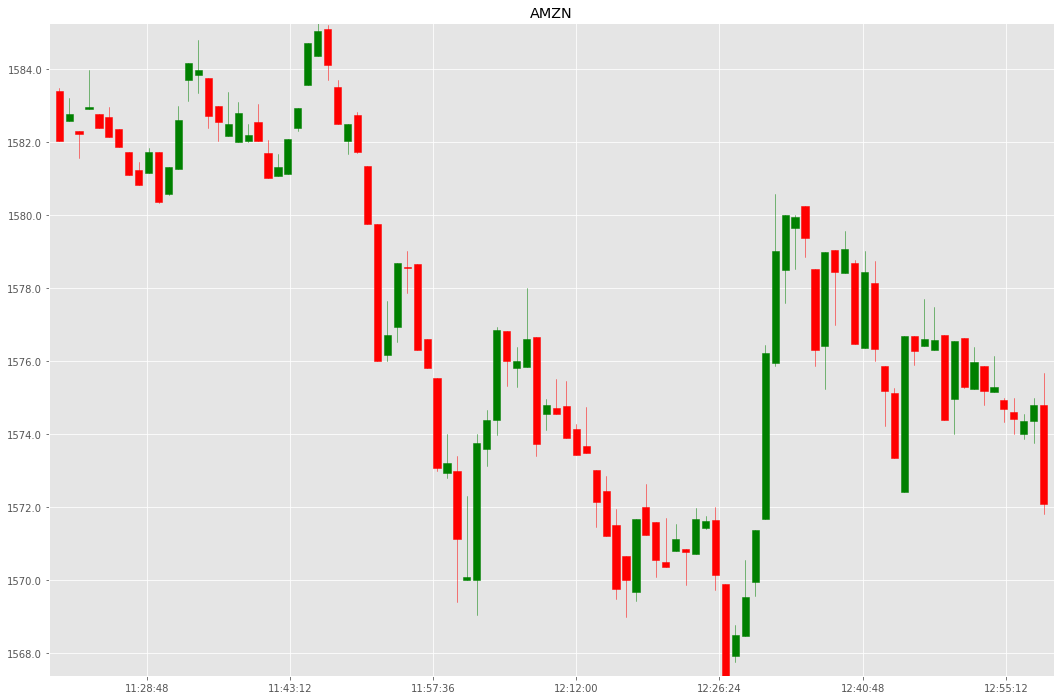

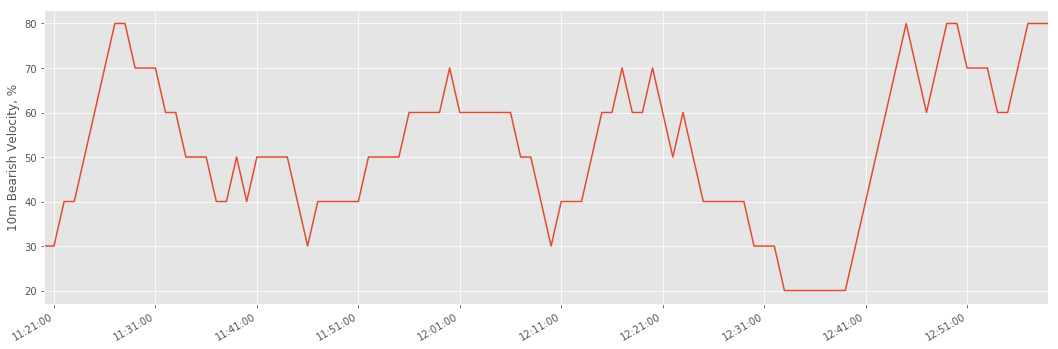

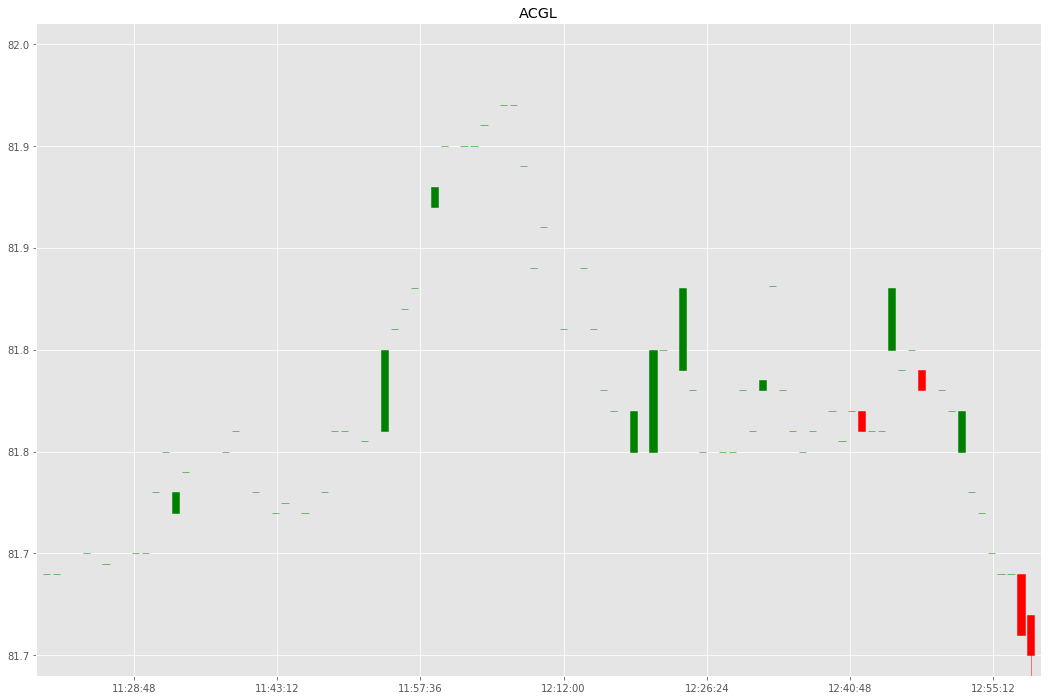

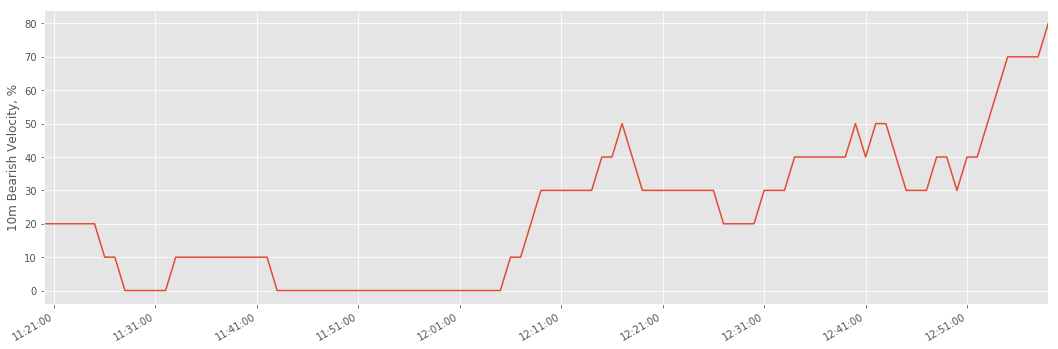

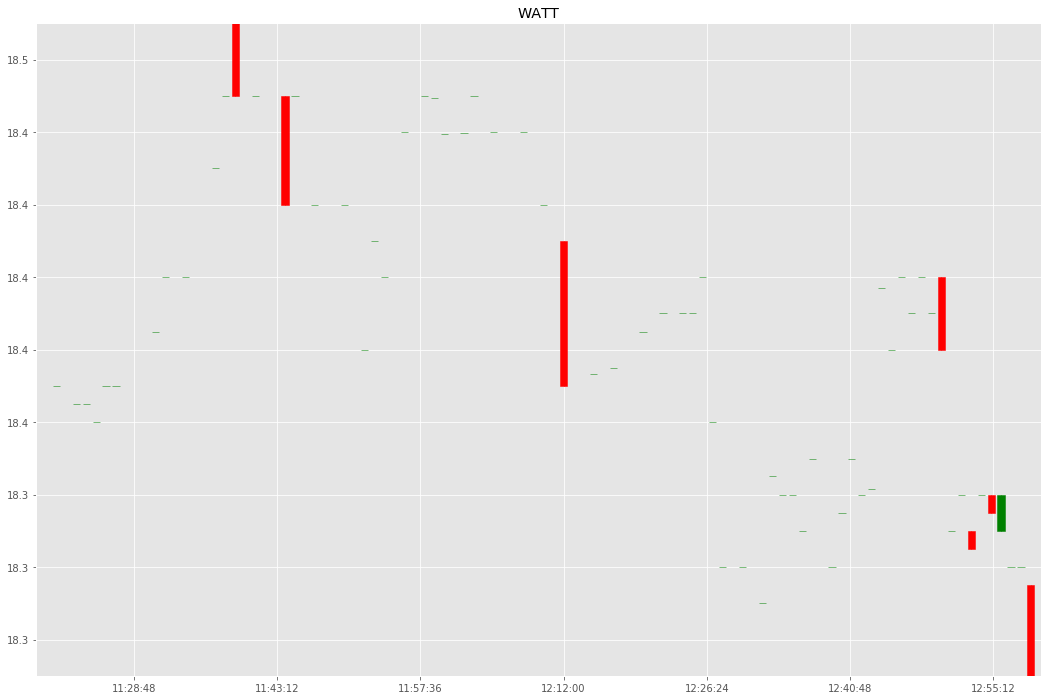

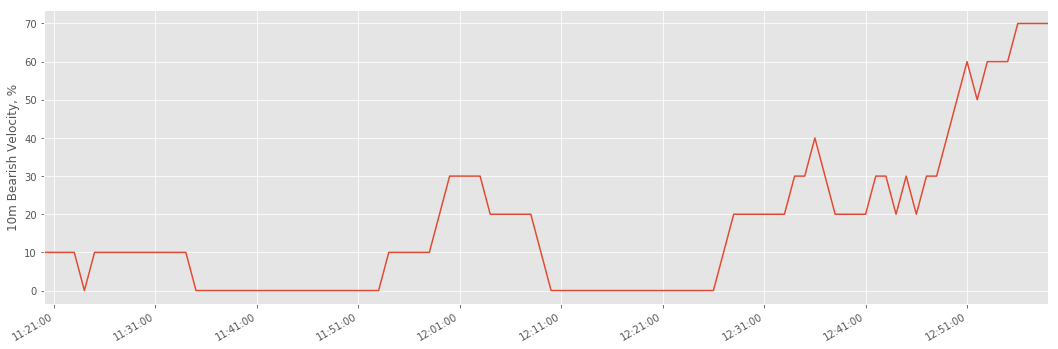

period 0:01:03.755585


In [ ]:
prev_time = None
timeFormatter = DateFormatter('%H:%M:%S', tz=CLIENT_TIMEZONE)
now = get_now()
symbols = get_symbols()

while True:
    start = datetime.now()    
    if prev_time:
        seconds_since_update = (start - prev_time).seconds
        if seconds_since_update < 60:
            sleep(60 - seconds_since_update)    
    
    top_symbols_data = load_data(symbols, now) 
    clear_output()
    
    display(HTML("<h3>Top 10 V Bottom Candidates</h3>"))
    
    table = "<table width='100%'>"\
            "<tr><th>10m Bear Velocity</th><th>Min Low / Open</th><th>Symbol</th>"\
            "<th>Close / Min Low</th><th>10m Bull Velocity</th></tr>"
    for symbol, df in top_symbols_data: 
        latest_row = df.iloc[-1]
        
        table += "<tr><td>{}</td><td>{}</td><td>{}</td><td>{}</td><td>{}</td></tr>".format(
            latest_row["bear_velocity"],
            latest_row["min_low_open"],
            symbol,
            latest_row["close_min_low"],
            latest_row["bull_velocity"],
        )
        
        # plot data
        sub_df = df[-100:]  
        
        fig = plt.figure(figsize=(18, 12)) 
        ax1 = plt.subplot(111)
        ax1.set_title(symbol)
        candlestick_ochl(
            ax1, 
            ((date2num(r.Index), r.open, r.close, r.high, r.low) for r in sub_df.itertuples()), 
            width=.0005,
            colorup='g',  
            colordown='r',
        )
        ax1.xaxis.set_major_formatter(timeFormatter)
        ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,p: "%.1f" % x))
        x_min = date2num(sub_df.index.min() - timedelta(seconds=60))
        x_max = date2num(sub_df.index.max() + timedelta(seconds=60))
        ax1.set_xlim(x_min, x_max)
        ax1.set_ylim(sub_df.low.min(), sub_df.high.max())  
        
        fig = plt.figure(figsize=(18, 6)) 
        ax2 = plt.subplot(111)
        sub_df.bear_velocity.plot()
        ax2.xaxis.set_major_formatter(timeFormatter)
        ax2.set_ylabel('10m Bearish Velocity, %')
        
    
    table += "</table>"    
    display(HTML(table))
    
    display(HTML("<h3>Individual charts</h3>"))
    
    plt.show()    
    
    print("period", (datetime.now() - start))
    prev_time = start